In [1]:
# Setup matplotlib to plot inline (within the notebook)
%matplotlib inline
# Import the pyplot module of Matplotlib as plt
import matplotlib.pyplot as plt
# Import pandas under the abbreviation 'pd'
import pandas as pd
# Import NumPy under the abbreviation 'np'
import numpy as np
# Libraries to aid in web scraping
import requests
from bs4 import BeautifulSoup
from datetime import datetime
import seaborn as sns;
#Notes for efficienccy:
#shift + tab when cursor is in arguments to bring up its documentation
#ex: pd.DataFrame(Shift+tab here)
#recall: Json == Dictionary
#to know functions of pandas:
#dir(pd)

In [2]:
# Getting the Cleaned Datasets
acquisC = pd.read_csv("datasets/startupsCleaned/acquisitionsCleaned.csv")
companiesC = pd.read_csv("datasets/startupsCleaned/companiesCleaned.csv", parse_dates=['founded_at', 'first_funding_at', 'last_funding_at', 'time_before_first_fund'])
investsC = pd.read_csv("datasets/startupsCleaned/investmentsCleaned.csv")
roundsC = pd.read_csv("datasets/startupsCleaned/roundsCleaned.csv")
dfAllC = [acquisC, companiesC, investsC, roundsC]
lstCsvNames = ["acquisitions", "companies", "investments", "rounds"]

In [3]:
# Getting important functions
def datasetsCols(dfList, datasetNames, pad=""):
    """
    Takes dataframes and returns a dataframe (df) with each column having a df's
    column names. The "pad" is to make sure all lists of columns have 
    the same length padded out with "pad"
    Example
    pad = "XX", datasetNames = ["cars", "planes"]
    dfList = [carsDF, planesDF]
    returned data frame:
            cars            planes
    0       numOfWheels     numOfWings
    1       manufacturer    manufacturer
    2       make            XX
    """
    cols = []
    maxArrayLen = 0
    for i, df in enumerate(dfList):
        cols.append(df.columns.tolist())
        maxArrayLen = max(maxArrayLen, len(cols[i]))
    
    dictCsvs = {}
    for i, df in enumerate(dfList):
        cols[i] += [pad] * (maxArrayLen - len(cols[i])) #padding the lists to make them have equal lengths 
        dictCsvs.update({datasetNames[i] : cols[i]})

    return pd.DataFrame(dictCsvs)

In [4]:
# Getting important functions (cont.)
def datasetsNulls(dfList, datasetNames, nullCol="nulls_", pad=""):
    """
    Use this when you want to display a column of column names,
    then a column of the null values, and repeat that for each dataset.
    Returns a dataframe
    """
    cols = []
    nulls = []
    maxArrayLen = 0
    for i, df in enumerate(dfList):
        cols.append(df.columns.tolist())
        nulls.append(df.isnull().sum().tolist())
        maxArrayLen = max(maxArrayLen, len(cols[i]))
    
    dictCsvs = {}
    for i, df in enumerate(dfList):
        cols[i] += [pad] * (maxArrayLen - len(cols[i])) #padding the lists to make them have equal lengths 
        nulls[i] += [None] *  (maxArrayLen - len(nulls[i]))
        dictCsvs[datasetNames[i]] = cols[i]
        dictCsvs[nullCol + str(i+1)] = nulls[i]
    
    return pd.DataFrame(dictCsvs)

## Question 1 (Ashraf)

* Do country taxes play an important factor in deciding a start-up’s success?
    - This can be determined by gathering information about each country’s tax revenues <br> and correlating the results with the status of a start-up.

### Scraping

#### Scraping Taxes

Using the website [kpmg](https://home.kpmg/eg/en/home/services/tax/tax-tools-and-resources/tax-rates-online/corporate-tax-rates-table.html) to get the taxes, we will choose the country to perform the analysis on based on two criteria:
1. there are relatively a lot of companies in `companies` dataset that are based in this country
2. the change to tax rate throughout the years for this country is noticable

Using `()` to chain methods and getting the **number** of countries present in `companies` dataset

Text(0, 0.5, 'Country')

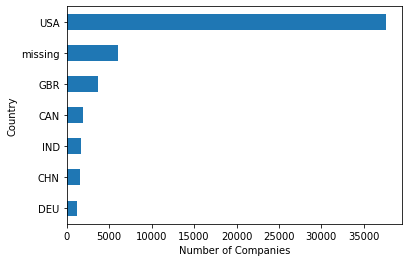

In [78]:
(
    companiesC
    .groupby('company_country_code')['company_name']
    .count()
    .sort_values(ascending=False)[0:7] #Sorting to generate a series with USA as first country, then missing, and so on
    .plot(kind="barh")
    .invert_yaxis() #using invert_yaxis() to make sure USA appears at the top, not at the bottom 
);
plt.xlabel("Number of Companies")
plt.ylabel("Country")

Getting the **ratio** of countries present in `companies` dataset

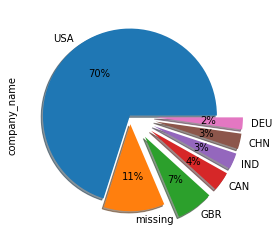

In [63]:
# note that "autopct" displays percentage of slices, 
# while "explode" gives a little space between each corresponding slice in the pie chart
(
    companiesC
    .groupby('company_country_code')['company_name']
    .count()
    .sort_values(ascending=False)[0:7]
    .plot(kind="pie", autopct='%1.0f%%', explode=[0.00,0.1,0.3,0.3,0.3,0.3,0.3], shadow=True)
);

Since `USA` represents 70% of the top 7 countries that have companies based in them. <br>
Therefore, `USA` satisfies condition `1.`

In [6]:
req = requests.get('https://home.kpmg/eg/en/home/services/tax/tax-tools-and-resources/tax-rates-online/corporate-tax-rates-table.html')
soup = BeautifulSoup(req.text, 'html.parser')
with open('kpmg.html', 'w', encoding="utf-8") as f:
    f.write(str(soup))


Displaying the retrieved page on chrome, we find the following: <br>
<img src='Phase 2/kpmgNotWorking.png' width=800 height=500>

Since the website uses javascript, `selenium` will be used instead of `requests`

In [7]:
from selenium import webdriver
import time
import warnings
warnings.filterwarnings('ignore') # to suppress warnings about internal code deprecations
options=webdriver.ChromeOptions()
options.add_argument('--incognito')
options.add_argument('--headless')
userAgent = 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'
options.add_argument(f'user-agent={userAgent}')
driver=webdriver.Chrome(options=options)
driver.get('https://home.kpmg/eg/en/home/services/tax/tax-tools-and-resources/tax-rates-online/corporate-tax-rates-table.html')

In [8]:
time.sleep(3) # sleeping to render javascript code before parsing to BeautifulSoup
soup = BeautifulSoup(driver.page_source, 'html.parser')

In [9]:
print(soup.prettify())

<html class="chrome" lang="en-US">
 <head class="chrome at-element-marker">
  <meta class="chrome" content="text/html; charset=utf-8" http-equiv="content-type"/>
  <meta class="chrome" content="Tue, 02 Aug 2016 11:22:32 GMT" http-equiv="date"/>
  <meta class="chrome" content="en-US" http-equiv="content-language"/>
  <meta class="chrome" content="text/html" http-equiv="content-encoding"/>
  <meta class="chrome" content="KPMG’s corporate tax table provides a view of corporate tax rates around the world." name="description"/>
  <meta charset="utf-8" class="chrome"/>
  <meta class="chrome" content="IE=edge,chrome=1" http-equiv="X-UA-Compatible"/>
  <link class="chrome" crossorigin="" href="https://assets.kpmg" rel="preconnect"/>
  <link class="chrome" crossorigin="" href="https://scripts.demandbase.com" rel="preconnect"/>
  <link class="chrome" crossorigin="" href="https://cdns.gigya.com" rel="preconnect"/>
  <link class="chrome" crossorigin="" href="https://fonts.gstatic.com" rel="preconn

Iframe problem:<br>
The obtained html doesn't show the content inside `iframe` tag, as `iframe` basically calls a new web page: <br>
<img src='Phase 2/emptyIframeUsingSelenium.png'>
<br><br>
actual content inside the iframe:<br>
<img src='Phase 2/notEmptyIframeGoogleInspector.png'>

Solution: retrieve page inside `src` key

In [10]:
iframe = soup.find('iframe', {'title':'taxrates'})
iframe

<iframe class="chrome" frameborder="0" height="6500px" scrolling="no" src="//s3.amazonaws.com/kpmg-global/tax-rates-tool/index_Corporate.html" title="taxrates" width="100%"></iframe>

In [11]:
tableLink = iframe.get('src')
tableLink

'//s3.amazonaws.com/kpmg-global/tax-rates-tool/index_Corporate.html'

In [12]:
tableLink = 'https:' + tableLink
driver.get(tableLink)
time.sleep(7) # sleeping a little longer, as the page loads in relatively longer time

In [13]:
soup = BeautifulSoup(driver.page_source, 'html.parser')

In [14]:
print(soup.prettify())

<html>
 <head>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
  <title>
   KPMG
  </title>
  <script language="JavaScript">
   var selectedTax = "Corporate"
  </script>
  <script language="JavaScript" src="js/jquery-1.6.2.min.js">
  </script>
  <script language="JavaScript" src="js/js-GM-PRGM-009.js">
  </script>
  <link href="css/style-GM-PRGM-009.css" rel="stylesheet" type="text/css"/>
 </head>
 <body>
  <div class="GMPRGM009ResponsiveTable">
   <table width="100%">
    <tbody>
     <tr>
      <th class="GMPRGM009xslTHLocation">
       Location
      </th>
      <th class="GMPRGM009xslTHFootnotes">
       2012
      </th>
      <th class="GMPRGM009xslTHFootnotes">
       2013
      </th>
      <th class="GMPRGM009xslTHFootnotes">
       2014
      </th>
      <th class="GMPRGM009xslTHFootnotes">
       2015
      </th>
      <th class="GMPRGM009xslTHFootnotes">
       2016
      </th>
      <th class="GMPRGM009xslTHFootnotes">
       2017
      </th>
      <th

part of the page's output: <br>
<img src='Phase 2/iframePage.png'>

`pd.read_html` takes a link or html as argument and converts all tables that it finds into dataframes <br>
But since the webpage only has one table, we will directly access it using `[0]`

In [15]:
taxesTable = pd.read_html(driver.page_source)
dfTaxes = taxesTable[0]
dfTaxes

,Location,2012,2013,2014,2015,2016,2017,2018,2019,2020,Footnotes
0,Afghanistan,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,+ Show
1,Albania,10.00,10.00,15.00,15.00,15.00,15.00,15.00,15.00,15.00,+ Show
2,Algeria,NaN,25.00,19.00,26.00,26.00,26.00,26.00,26.00,26.00,+ Show
3,Andorra,NaN,NaN,NaN,NaN,NaN,10.00,10.00,10.00,10.00,+ Show
4,Angola,35.00,35.00,35.00,30.00,30.00,30.00,30.00,30.00,30.00,+ Show
...,...,...,...,...,...,...,...,...,...,...,...
178,Latin America average,28.30,27.96,27.31,27.16,27.29,27.98,28.20,27.39,27.36,NaN
179,North America average,33.00,33.00,33.25,33.25,33.25,33.25,26.75,26.75,26.75,NaN
180,Oceania average,28.60,27.00,27.00,27.00,27.00,28.43,28.43,28.43,28.43,NaN
181,OECD average,25.18,25.32,24.98,24.77,24.69,23.95,23.53,23.23,23.05,NaN


#### Scraping `USA` Companies

In [110]:
#getting the number of companies that were founded after 2014
len(companiesC[companiesC.founded_at >= pd.Timestamp(2015, 1, 1)])

1577

Since the companies in the current dataset that were founded after 2014 are very few, <br> 
Therefore, we will get scrape `USA` countries that were founded after 2014. <br>
The reason for choosing `USA` will be stated later in the notebook

In [ ]:
#TO DO

### Cleaning

In [16]:
# "footnotes" is useless, so we will remove it:
dfTaxes.drop(columns='Footnotes', inplace=True)

using `apply()` and user-defined function on each row:

In [17]:
#converting country names to country codes:
import pycountry
def toCountryCode(row):
    country = row[0]
    try:
        row[0] = pycountry.countries.get(name=country).alpha_3
    except:
        row[0] = country[0:3].upper() #if not found in pycountry, assume that it is the first 3 letters of the country name
    return row

Recall:
* **Axis 0** will act on all the rows in **each column**
* **Axis 1** will act on all the columns in **each row**
<br>
[source](https://stackoverflow.com/questions/22149584/what-does-axis-in-pandas-mean#:~:text=it%20this%20way%3A-,Axis%200%20will%20act,COLUMNS%20in%20each%20ROW,-So%20a%20mean)

In [18]:
dfTaxesCountryCodes = dfTaxes.apply(toCountryCode, axis=1)
dfTaxesCountryCodes

,Location,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,AFG,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00
1,ALB,10.00,10.00,15.00,15.00,15.00,15.00,15.00,15.00,15.00
2,DZA,NaN,25.00,19.00,26.00,26.00,26.00,26.00,26.00,26.00
3,AND,NaN,NaN,NaN,NaN,NaN,10.00,10.00,10.00,10.00
4,AGO,35.00,35.00,35.00,30.00,30.00,30.00,30.00,30.00,30.00
...,...,...,...,...,...,...,...,...,...,...
178,LAT,28.30,27.96,27.31,27.16,27.29,27.98,28.20,27.39,27.36
179,NOR,33.00,33.00,33.25,33.25,33.25,33.25,26.75,26.75,26.75
180,OCE,28.60,27.00,27.00,27.00,27.00,28.43,28.43,28.43,28.43
181,OEC,25.18,25.32,24.98,24.77,24.69,23.95,23.53,23.23,23.05


using `melt()` to change years in the header to values under the new column name `Year`

In [19]:
dfTaxesMelted = dfTaxesCountryCodes.melt(id_vars='Location', var_name='Year', value_name='TaxRate')
dfTaxesMelted

,Location,Year,TaxRate
0,AFG,2012,20.00
1,ALB,2012,10.00
2,DZA,2012,NaN
3,AND,2012,NaN
4,AGO,2012,35.00
...,...,...,...
1642,LAT,2020,27.36
1643,NOR,2020,26.75
1644,OCE,2020,28.43
1645,OEC,2020,23.05


In [20]:
dfTaxesMelted.dtypes

Location     object
Year         object
TaxRate     float64
dtype: object

converting to `int` to be able to merge with `founded_at_year` (obtained later)

In [21]:
dfTaxesMelted.Year = dfTaxesMelted.Year.astype(int)
dfTaxesMelted.dtypes

Location     object
Year          int32
TaxRate     float64
dtype: object

Checking that `USA` has a nice gap between tax rates

In [22]:
dfTaxesMelted[dfTaxesMelted['Location'] == 'USA']

,Location,Year,TaxRate
163,USA,2012,40.0
346,USA,2013,40.0
529,USA,2014,40.0
712,USA,2015,40.0
895,USA,2016,40.0
1078,USA,2017,40.0
1261,USA,2018,27.0
1444,USA,2019,27.0
1627,USA,2020,27.0


Thus, `USA` satisfies condition `2.` and thus will be used for this question

In [23]:
companiesC.founded_at.head(3)

0   2011-04-12 20:46:43.240577680
1   2014-09-04 00:00:00.000000000
2   2010-05-07 20:46:43.240577680
Name: founded_at, dtype: datetime64[ns]

Using `dt.year` to extract the year only from `datetime` datatype

In [24]:
companiesC.founded_at.dt.year.head(3)

0    2011.0
1    2014.0
2    2010.0
Name: founded_at, dtype: float64

In [25]:
companiesC.founded_at.isnull().sum()

1

dropping `NaNs` so that we can create `founded_at_year` as `int`

In [26]:
companiesC.dropna(subset='founded_at', inplace=True)
companiesC.founded_at.isnull().sum()

0

In [27]:
companiesC['founded_at_year'] = companiesC.founded_at.dt.year.astype(int)
companiesC.founded_at_year

0        2011
1        2014
2        2010
3        2007
4        2010
         ... 
66321    2008
66322    2012
66323    2011
66324    2014
66325    2010
Name: founded_at_year, Length: 66325, dtype: int32

### Integrating (Merging)

Using `pd.merge()` to merge `companiesC` and `dfTaxesMelted` based on the country and the year

In [28]:
usaCompaniesTaxes = pd.merge(companiesC, dfTaxesMelted, how='inner', left_on=['company_country_code', 'founded_at_year'], right_on=['Location', 'Year'])
usaCompaniesTaxes = usaCompaniesTaxes[usaCompaniesTaxes['company_country_code'] == 'USA']
usaCompaniesTaxes.shape

(10121, 17)

In [29]:
usaCompaniesTaxesOuter = pd.merge(companiesC, dfTaxesMelted, how='outer', left_on=['company_country_code', 'founded_at_year'], right_on=['Location', 'Year'])
usaCompaniesTaxesOuter = usaCompaniesTaxesOuter[usaCompaniesTaxesOuter['company_country_code'] == 'USA']
usaCompaniesTaxesOuter.shape

(37580, 17)

Notice that when we used inner join, the number of companies decreased from 10121 to 37580; <br>
that's because the rest of the companies were founded before 2014 (first date in `dfTaxesMelted` dataframe) <br>
However, 10000+ are still a lot of companies, so we'll continue the analysis on `USA`

In [30]:
usaCompaniesTaxes.columns

Index(['company_permalink', 'company_name', 'homepage_url',
       'company_category_list', 'funding_total_usd', 'status',
       'company_country_code', 'company_city', 'funding_rounds', 'founded_at',
       'first_funding_at', 'last_funding_at', 'time_before_first_fund',
       'founded_at_year', 'Location', 'Year', 'TaxRate'],
      dtype='object')

dropping `Location` and `Year` since they're redundent info

In [31]:
usaCompaniesTaxes.drop(columns=['Location', 'Year'], inplace=True)
usaCompaniesTaxes.columns

Index(['company_permalink', 'company_name', 'homepage_url',
       'company_category_list', 'funding_total_usd', 'status',
       'company_country_code', 'company_city', 'funding_rounds', 'founded_at',
       'first_funding_at', 'last_funding_at', 'time_before_first_fund',
       'founded_at_year', 'TaxRate'],
      dtype='object')

using `pop()` and `insert()` to shift the `founded_at_year` column to be next to `founded_at` column for aesthetic reasons :]

In [32]:
columnValues = usaCompaniesTaxes.pop("founded_at_year")
usaCompaniesTaxes.insert(10, "founded_at_year", columnValues)
usaCompaniesTaxes.columns

Index(['company_permalink', 'company_name', 'homepage_url',
       'company_category_list', 'funding_total_usd', 'status',
       'company_country_code', 'company_city', 'funding_rounds', 'founded_at',
       'founded_at_year', 'first_funding_at', 'last_funding_at',
       'time_before_first_fund', 'TaxRate'],
      dtype='object')

### Visualizing

Now, let's evaluate how taxes affect companies. 3 features will be chosen for the evaluation:
1. `funding_total_usd`
2. `funding_rounds`
3. `status`

Correlating taxes with total fundings by getting their average in each year

In [99]:
usaCompaniesTaxes.founded_at_year.unique()

array([2014, 2013, 2012, 2015, 2016])

In [98]:
taxTotalFundsUSA = (usaCompaniesTaxes[['founded_at_year', 'TaxRate', 'funding_total_usd']]
                    .groupby(['founded_at_year', 'TaxRate'])
                    .mean()
                    .round(0)
                    .style.format("{:,}"))
taxTotalFundsUSA

,,funding_total_usd
founded_at_year,TaxRate,
2012,40.000000,"6,834,733.0"
2013,40.000000,"5,408,257.0"
2014,40.000000,"2,584,137.0"
2015,40.000000,"1,735,902.0"
2016,40.000000,0.0


## QUESTION THAT IS RELATED TO EGYPT

In [33]:
companiesC.groupby('company_country_code')['company_name'].count().loc['EGY']

36